## Загрузка данных

In [75]:
import json
import pandas as pd
import numpy as np

from data_preprocessing import get_sparse_matrix

Номенклатура и целевые товары:

In [76]:
nom = pd.read_parquet('data/nomenclature.parquet')

In [77]:
target_types_nom = {'Соки и сокосодержащие напитки', 'Снеки', 'Вода',
                    'Сладкие Уранированные напитки, холодный чай',
                    'Кофейные напитки с молоком', 'Энергетические напитки'}

In [78]:
target_ids = nom.sku_id[nom.sku_group.isin(target_types_nom)]

Разреженная матрица:

In [79]:
code_in = {indx:nom.sku_id.iloc[indx] for indx in nom.sku_id.index}
code_out = {nom.sku_id.iloc[indx]:indx for indx in nom.sku_id.index}

In [80]:
train_sparse, _, _ = get_sparse_matrix('json_data_train', code_in)

In [81]:
train_sparse

<200000x5103 sparse matrix of type '<class 'numpy.float32'>'
	with 466328 stored elements in Compressed Sparse Row format>

## Baseline

Реализуем baseline в виде модели, которая каждому клиенту предлагает $20$ наиболее популярных целевых товаров исходя из всех транзакций. То есть не персонализированное предложение.

Расчитаем качество данной модели и от результата будем отталкиваться.

In [82]:
# посчитаем сумму:
total = np.array(train_sparse.sum(axis=0)).flatten()

In [83]:
# отсортируем и раскодируем товары:
sorted_all = np.vectorize(code_out.get)(total.argsort())

In [84]:
# выберем те товары, которые входят в целевые:
sorted_target = sorted_all[np.isin(sorted_all, target_ids.values)]

In [85]:
# 20 наиболее популярных товаров.
# не забываем, что сортировка от наим. к наиб.:
best20 = np.flip(sorted_target[-20:])
best20

array([1551, 2673, 3839,  403,  817,  433,  431,  229,  580,   99,   98,
        434,  400,  408, 1903, 1197, 4522,  200, 1571, 1533])

Посмотрим, что это за товары:

In [86]:
best20_df = pd.DataFrame({'full_name': [], 'sku_group': []})

for sku in best20:
    best20_df = best20_df.append(nom[['full_name', 'sku_group']][nom.sku_id==sku])

In [87]:
best20_df

,full_name,sku_group
3725,unknown,Кофейные напитки с молоком
3788,unknown,Кофейные напитки с молоком
3731,unknown,Кофейные напитки с молоком
343,Вода evian минеральная неУранированная стекло ...,Вода
357,Вода Святой Источник питьевая неУранированная ...,Вода
2642,Напиток Burn энергетический оригинальный ж/б 0...,Энергетические напитки
3457,Напиток Red Bull White Edition энергетический ...,Энергетические напитки
1687,Напиток Red Bull Blue Edition энергетический ж...,Энергетические напитки
527,"Вода BONAQUA питьевая неУранированная ПЭТ 0,5л",Вода
3408,Напиток Schweppes Уранированный spritz аперити...,"Сладкие Уранированные напитки, холодный чай"


Проверим показатель метрики. Загрузим тестовые данные:

In [88]:
file_path = 'json_data_target/target_data.json'
with open(file_path, 'r') as read_file:
    test_data = json.load(read_file)

Рассчитаем предсказания:

In [89]:
import copy

In [90]:
predict_data = copy.deepcopy(test_data)
for client in predict_data['clients']:
    client['predict'] = list(best20)

Реализуем функцию для расчета метрики:

In [91]:
def pres_at_k(target, predict, k):
    ri = [t==p for (i, (t,p)) in enumerate(zip(target, predict)) if i<k]
    return sum(ri) / k

In [92]:
def average_pres_at20(target, predict):
    r = [t==p for (t,p) in zip(target, predict)]
    pk = [pres_at_k(target, predict, k)*r[k-1] for k in range(1, 21)]
    return sum(pk) / 20

In [93]:
def map20(targets, predicts):
    ap_i = [average_pres_at20(ti, pi) for (ti,pi) in zip(targets, predicts)]
    return sum(ap_i) / len(targets)

Расчитаем значение метрики для первого решения:

In [94]:
targets, predicts = [], []
for client in predict_data['clients']:
    targets.append(client['target'])
    predicts.append(client['predict'])
    
best20_map = map20(targets, predicts)
best20_map

5.833333333333333e-05

Результат по метрике: $0.0000583$.

Данное значение метрики будет опорной точкой. Будем применять более сложные модели и смотреть на разницу качества.

## ALS

Применим модель ALS, основанную на разложении матрицы (Клиент-Товар). Для этого воспользуемся библиотекой `implicit`.

In [95]:
# !pip install implicit

In [96]:
import implicit

In [97]:
train_sparse

<200000x5103 sparse matrix of type '<class 'numpy.float32'>'
	with 466328 stored elements in Compressed Sparse Row format>

Создадим модель:

In [98]:
model_als = implicit.als.AlternatingLeastSquares(factors=24,
                                                 regularization=0.0,
                                                 iterations=16,
                                                 random_state=2021)

In [99]:
# ALS implicit в методе fit принимает матрицу (Товар-Клиент)
model_als.fit(train_sparse.T)

Для предсказаний преобразуем тестовые данные в разреженную матрицу:

In [100]:
from scipy import sparse
from collections import defaultdict

In [101]:
def get_sparse_matrix_from_target(path, code_in):
    with open(path, 'r') as read_file:
        target_group = json.load(read_file)
        indx_row_list, indx_col_list = [], []
        values_list = []
        # ID клиента и номер чека:
        clients_ids = []  # ID клиентов
        cheqs_ids = []  # ID чеков
        c = 0
        for client in target_group['clients']:  # пройдем по всем клиентам
            # ID клиента и номер чека:
            clients_ids.append(client['client_id'])
            cheqs_ids.append(client['cheque_id'])
            for indx in client['sku_ids']:
                indx_col_list.append(code_in[int(indx)])  # индексы по столбцам
                values_list.append(client['sku_ids'][indx])  # значения
            indx_row_list.extend([c]*len(client['sku_ids'].keys()))  # индексы по строкам
            c += 1
        sparse_matrix = sparse.coo_matrix(
            (np.array(values_list, dtype=np.float32), (indx_row_list, indx_col_list)),
            shape=(c, len(code_in.keys())))
        return sparse_matrix.tocsr(), clients_ids, cheqs_ids

In [102]:
filepath = 'json_data_target/target_data.json'
target_sparse, _, _ = get_sparse_matrix_from_target(filepath, code_in)

In [103]:
target_sparse

<1000x5103 sparse matrix of type '<class 'numpy.float32'>'
	with 2344 stored elements in Compressed Sparse Row format>

Реализуем предсказания:

In [104]:
predict_ALS_data = copy.deepcopy(test_data)

In [120]:
for cl_i in range(len(predict_ALS_data['clients'])):
    sparse_row = target_sparse.getrow(cl_i)
    predi = model_als.recommend(0,
                                sparse_row,  # для данного клиента
                                N=974,  # количество рекомендаций (возьмем количество всех целевых товаров)
                                filter_already_liked_items=False,  # можно предлагать те же товары, что клиент уже покупал
                                recalculate_user=True)  # пересчитываем эмбединги для нового клиента
    predi_all = np.array([code_out[pr[0]] for pr in predi])  # рекомендации из всех товаров
    predi_targ = predi_all[np.isin(np.array(predi_all), target_ids.values)]  # рекомендации из целевой группы
    # заполнять будем теми товарами, которых нет в чеке клиента:
    predi_targ = predi_targ[~np.isin(predi_targ, sparse_row.nonzero()[1])]
    # если целевых рекомендованных меньше 20, то
    # оставшиеся заполним наиболее популярными среди всех клиентов:
    if predi_targ.shape[0] < 20:
        unique_b20 = best20[~np.isin(best20, predi_targ)]
        resi = np.hstack([predi_targ, unique_b20])[:20]
    else:
        resi = predi_targ[:20].copy()
    # добавим рекомендации к пользователю:
    predict_ALS_data['clients'][cl_i]['predict'] = resi.tolist()

Проверим качество:

In [121]:
targets, predicts = [], []
for client in predict_ALS_data['clients']:
    targets.append(client['target'])
    predicts.append(client['predict'])

als_map = map20(targets, predicts)
als_map

8.345704948646125e-05

Результат по метрике: $0.0000834$.

Получили небольшое улучшение:

In [122]:
round(als_map / best20_map, 2)

1.43

## Item2Item

Данный метод основан на рассчете "похожести" между купленными товарами. Для каждого товара будет составлен список тех товаров, которые наиболее часто покупают вместе с этим товаром. Похожесть рассчитывается на основании косинусного расстояния.

Данный метод показывает себя хорошо в случае, когда товаров существенно меньше, чем клиентов, что справделиво в нашей задаче.

In [123]:
model_i2i = implicit.nearest_neighbours.CosineRecommender(K=974)
# K - количество похожих продуктов для каждого продукта в чеке клиента

In [124]:
model_i2i.fit(train_sparse.T)

Оценим качество результатов:

In [125]:
predict_item2item_data = copy.deepcopy(test_data)

In [126]:
for cl_i in range(len(predict_item2item_data['clients'])):
    sparse_row = target_sparse.getrow(cl_i)
    predi = model_i2i.recommend(0,
                                sparse_row,  # для данного клиента
                                N=974,  # количество рекомендаций (возьмем количество всех целевых товаров)
                                filter_already_liked_items=False,  # можно предлагать те же товары, что клиент уже покупал
                                recalculate_user=True)  # пересчитываем эмбединги для нового клиента
    predi_all = np.array([code_out[pr[0]] for pr in predi])  # рекомендации из всех товаров
    predi_targ = predi_all[np.isin(np.array(predi_all), target_ids.values)]  # рекомендации из целевой группы
    # заполнять будем теми товарами, которых нет в чеке клиента:
    predi_targ = predi_targ[~np.isin(predi_targ, sparse_row.nonzero()[1])]
    # если целевых рекомендованных меньше 20, то
    # оставшиеся заполним наиболее популярными среди всех клиентов:
    if predi_targ.shape[0] < 20:
        unique_b20 = best20[~np.isin(best20, predi_targ)]
        resi = np.hstack([predi_targ, unique_b20])[:20]
    else:
        resi = predi_targ[:20].copy()
    # добавим рекомендации к пользователю:
    predict_item2item_data['clients'][cl_i]['predict'] = resi.tolist()

In [127]:
targets, predicts = [], []
for client in predict_item2item_data['clients']:
    targets.append(client['target'])
    predicts.append(client['predict'])

item2item_map = map20(targets, predicts)
item2item_map

0.0001840079365079365

Кратность прироста качества относительно baseline'а:

In [128]:
round(item2item_map / best20_map, 2)

3.15

Параметр $K=974$ говорит, что для каждого товара, который покупает клиент, будут подобраны $974$ наиболее близких товара. А на стадии предсказания, из всех этих $974\times$#, где # - количество товаров в чеке клиента, будут выбраны $N=974$ наилучших товаров (ближайших). Попробуем проварьировать количество соседей $K$ для каждого товара в чеке и посмотрим на результаты.

In [129]:
from tqdm.notebook import tqdm

In [130]:
i2i_models = []
ks = range(981, 0, -20)

# обучение моделей:
for k in ks:
    i2i_models.append(implicit.nearest_neighbours.CosineRecommender(K=k))
print('Обучение моделей:')
for m in tqdm(i2i_models):
    m.fit(train_sparse.T, show_progress=False)

# предсказания:
print('Построение предсказаний:')
metric_values = []
for m in tqdm(i2i_models):
    predict_item2item_data = copy.deepcopy(test_data)
    for cl_i in range(len(predict_item2item_data['clients'])):
        sparse_row = target_sparse.getrow(cl_i)
        predi = m.recommend(0,
                            sparse_row.getrow(cl_i),
                            N=974,
                            filter_already_liked_items=False,
                            recalculate_user=True)
        predi_all = np.array([code_out[pr[0]] for pr in predi])
        predi_targ = predi_all[np.isin(np.array(predi_all), target_ids.values)]
        predi_targ = predi_targ[~np.isin(predi_targ, sparse_row.nonzero()[1])]
        if predi_targ.shape[0] < 20:
            unique_b20 = best20[~np.isin(best20, predi_targ)]
            resi = np.hstack([predi_targ, unique_b20])[:20]
        else:
            resi = predi_targ[:20].copy()
        predict_item2item_data['clients'][cl_i]['predict'] = resi.tolist()
    
    targets, predicts = [], []
    for client in predict_item2item_data['clients']:
        targets.append(client['target'])
        predicts.append(client['predict'])
    metric_values.append(map20(targets, predicts))

Обучение моделей:



Построение предсказаний:


Визуализация:

In [131]:
import matplotlib.pyplot as plt

In [132]:
l = len(metric_values)
mmax = max(metric_values)
max_m_index = np.argsort(np.array(metric_values))[-1]

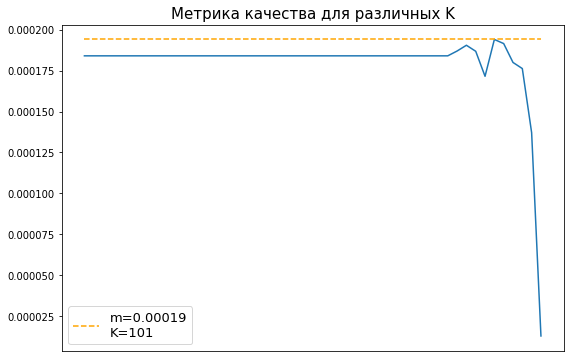

In [133]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(l), metric_values)
ax.plot(range(l), [mmax]*l, 'r--', color='orange',
        label='m={}\nK={}'.format(round(mmax,5), ks[max_m_index]))
ax.set_title('Метрика качества для различных K', fontsize=15)
ax.legend(fontsize=13)
plt.tick_params(axis='x', which='both',
                bottom=False, top=False, labelbottom=False)
plt.show()

Воспользуемся данным параметром $K$ для построения основной модели:

In [134]:
model_i2i = implicit.nearest_neighbours.CosineRecommender(K=ks[max_m_index])
model_i2i.fit(train_sparse.T)

In [135]:
predict_item2item_data = copy.deepcopy(test_data)

In [145]:
for cl_i in range(len(predict_item2item_data['clients'])):
    sparse_row = target_sparse.getrow(cl_i)
    predi = model_i2i.recommend(0,
                                sparse_row,
                                N=974,
                                filter_already_liked_items=False,
                                recalculate_user=True)
    predi_all = np.array([code_out[pr[0]] for pr in predi])
    predi_targ = predi_all[np.isin(predi_all, target_ids.values)]
    predi_targ = predi_targ[~np.isin(predi_targ, sparse_row.nonzero()[1])]
    if predi_targ.shape[0] < 20:
        unique_b20 = best20[~np.isin(best20, predi_targ)]
        resi = np.hstack([predi_targ, unique_b20])[:20]
    else:
        resi = predi_targ[:20].copy()
    predict_item2item_data['clients'][cl_i]['predict'] = resi.tolist()

In [146]:
targets, predicts = [], []
for client in predict_item2item_data['clients']:
    targets.append(client['target'])
    predicts.append(client['predict'])

item2item_map = map20(targets, predicts)
item2item_map

0.00019400793650793652

Кратность прироста:

In [147]:
round(item2item_map / best20_map, 2)

3.33

## User2User

На самом деле здесь мы будем делать тоже самое, что делали при построении тестовых данных. Но в этот раз возьмем б**о**льшее количество соседей для одного клиента.

In [148]:
from sklearn.decomposition import TruncatedSVD

In [149]:
svd = TruncatedSVD(n_components=128)
train_svd = svd.fit_transform(train_sparse)

In [150]:
test_svd = svd.transform(target_sparse)

In [151]:
from sklearn.neighbors import NearestNeighbors

In [152]:
neighbors_size = 256

In [153]:
knn_model = NearestNeighbors(n_neighbors=neighbors_size, metric='cosine')
knn_model.fit(train_svd)

NearestNeighbors(metric='cosine', n_neighbors=256)

In [154]:
predict_user2user_data = copy.deepcopy(test_data)

In [155]:
for cl_i in tqdm(range(len(predict_user2user_data['clients']))):

    # найдем соседей (клиентов, делающих похожие покупки) для
    # конкретного клиента из тестовой выборки
    neighs_ids = knn_model.kneighbors(test_svd[cl_i].reshape(1, -1),
                                      n_neighbors=neighbors_size,
                                      return_distance=False).tolist()[0]
    # соберем все покупки соседей:
    purchases = defaultdict(int)
    for neigh_id in neighs_ids:
        neigh = train_sparse.getrow(neigh_id)
        nonzer_indexs = neigh.nonzero()
        for key in nonzer_indexs[1]:
            purchases[key] += 1
    # отсортируем по количеству покупок:
    sorted_p = np.array(sorted(purchases, key=lambda x: purchases[x], reverse=True))
    # выберем целевые
    predi_targ = sorted_p[np.isin(sorted_p, target_ids)]
    # заполнять будем теми товарами, которых нет в чеке клиента:
    sparse_row = target_sparse.getrow(cl_i)
    predi_targ = predi_targ[~np.isin(predi_targ, sparse_row.nonzero()[1])]
    # если количество меньше 20, то остальные
    # заполним наиболее популярными среди всех клиентов:
    if predi_targ.shape[0] < 20:
        unique_b20 = best20[~np.isin(best20, predi_targ)]
        resi = np.hstack([predi_targ, unique_b20])[:20]
    else:
        resi = predi_targ[:20].copy()
    predict_user2user_data['clients'][cl_i]['predict'] = resi.tolist()

Оценим качество результата:

In [156]:
targets, predicts = [], []
for client in predict_user2user_data['clients']:
    targets.append(client['target'])
    predicts.append(client['predict'])

user2user_map = map20(targets, predicts)
user2user_map

8.08946608946609e-05

Кратность прироста:

In [157]:
round(user2user_map / best20_map, 2)

1.39

Посмотрим на динамику качетсва при уменьшении числа соседей:

In [158]:
ks = [256, 200, 128, 90, 64, 32, 25, 16, 8, 4]
metr_vals = []
for k in tqdm(ks):
    # модель:
    neighbors_size = k
    knn_model = NearestNeighbors(n_neighbors=neighbors_size, metric='cosine')
    knn_model.fit(train_svd)
    # предсказание:
    predict_user2user_models_data = copy.deepcopy(test_data)
    for cl_i in tqdm(range(len(predict_user2user_data['clients']))):
        neighs_ids = knn_model.kneighbors(test_svd[cl_i].reshape(1, -1),
                                          n_neighbors=neighbors_size,
                                          return_distance=False).tolist()[0]
        purchases = defaultdict(int)
        for neigh_id in neighs_ids:
            neigh = train_sparse.getrow(neigh_id)
            nonzer_indexs = neigh.nonzero()
            for key in nonzer_indexs[1]:
                purchases[key] += 1
        sorted_p = np.array(sorted(purchases, key=lambda x: purchases[x], reverse=True))
        predi_targ = sorted_p[np.isin(sorted_p, target_ids)]
        if predi_targ.shape[0] < 20:
            unique_b20 = best20[~np.isin(best20, predi_targ)]
            resi = np.hstack([predi_targ, unique_b20])[:20]
        else:
            resi = predi_targ[:20].copy()
        predict_user2user_models_data['clients'][cl_i]['predict'] = resi.tolist()
    # метрика:
    targets, predicts = [], []
    for client in predict_user2user_models_data['clients']:
        targets.append(client['target'])
        predicts.append(client['predict'])

    metr_vals.append(map20(targets, predicts))

In [163]:
l_u2u = len(metr_vals)
u2u_max = max(metr_vals)
u2u_max_m_index = np.argsort(np.array(metr_vals))[-1]

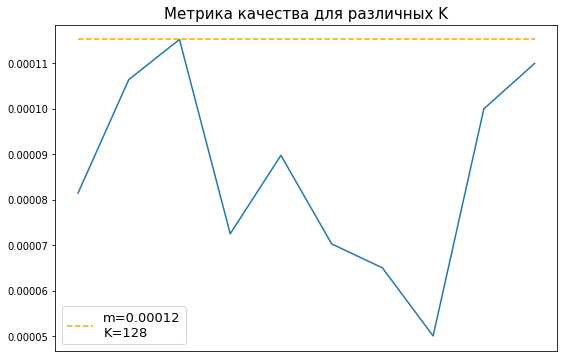

In [167]:
fig, ax = plt.subplots(figsize=(9,6))
ax.plot(range(l_u2u), metr_vals)
ax.set_title('Метрика качества для различных K', fontsize=15)
ax.plot(range(l_u2u), [u2u_max]*l_u2u, 'r--', color='orange',
        label='m={}\nK={}'.format(round(u2u_max,5), ks[u2u_max_m_index]))
ax.legend(fontsize=13)
plt.tick_params(axis='x', which='both',
                bottom=False, top=False, labelbottom=False)
plt.show()

При меньшем количестве соседей метрика принимает более высокое значение, но все еще слишком маленькое отностиельно модели Item2Item.

In [168]:
u2u_max

0.00011527777777777778

In [169]:
round(u2u_max / best20_map, 2)

1.98

**Результаты по первым моделям**

Модель|Метрика|Коэффициент прироста относительно Baseline
:-:|:-:|:-:
Baseline|$0.000058$|$-$
ALS|$0.000083$|$1.43$
Item2Item|$0.000194$|$3.33$
User2User|$0.000115$|$1.98$

Модель Item2Item показала наилучший результат среди остальных.

Функцию `get_sparse_matrix_from_target` сохраним в файл `data_preprocessing.py`. И также модель Item2Item реализуем в отдельном файле `i2i.py`.